In [85]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams, pos_tag
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.stats import entropy
import pandas as pd
import numpy as np
import networkx as nx
import re
import plotly.graph_objects as go
import plotly.io as pio
from bs4 import BeautifulSoup
import spacy
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [38]:
import en_core_web_sm

ModuleNotFoundError: No module named 'en_core_web_sm'

In [37]:
pip install en_core_web_sm

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement en_core_web_sm (from versions: none)
ERROR: No matching distribution found for en_core_web_sm


In [3]:
df = pd.read_csv('./scraped_articles_new.csv')

In [4]:
df

,Link,Text
0,https://www.channelnewsasia.com/singapore/bill...,SINGAPORE: A 45-year-old man linked to Singapo...
1,https://edition.cnn.com/2023/09/29/business/st...,New York CNN —\n\nStarbucks violated federal l...
2,https://edition.cnn.com/2023/05/22/tech/meta-f...,London CNN —\n\nMeta has been fined a record-b...
3,https://edition.cnn.com/2024/03/05/politics/li...,CNN —\n\nThe Department of Education imposed a...
4,https://www.euronews.com/2024/02/23/judge-conv...,The former Austrian Chancellor was given an ei...
...,...,...
1504,https://www.bbc.com/news/world-europe-57965260,German lawyers wrangle over pensioner's WW2 ta...
1505,https://www.bbc.com/news/uk-wales-mid-wales-13...,An air exclusion zone for unmanned aircraft ov...
1506,https://www.channelnewsasia.com/commentary/mal...,FLAWED BUSINESS PLANS\n\nMavcom initially awar...
1507,https://www.straitstimes.com/singapore/parliam...,"Under the Bill, MAS has the power to regulate ..."


In [5]:
def clean_text_with_ner(text):
    if not isinstance(text, str):
        return ""
    
    # Keep original text for entity positions
    original_text = text
    
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Load spaCy model
    nlp = spacy.load("en_core_web_sm")
    
    # Process text with spaCy
    doc = nlp(text)
    
    # Get entity positions and text
    entities = [(ent.text, ent.start_char, ent.end_char) for ent in doc.ents]
    
    # Convert text to lowercase
    text = text.lower()
    
    # Restore original case for entities
    for ent_text, start, end in entities:
        text = text[:start] + ent_text + text[end:]
    
    # Clean special characters while preserving currency and decimals
    text = re.sub(r'[^a-zA-Z0-9\s$€£¥.,]', '', text)
    
    # Handle decimal numbers and currency
    text = re.sub(r'(?<=\d),(?=\d{3})', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [6]:
df['cleaned_text'] = df['Text'].apply(clean_text_with_ner)

In [7]:
df['cleaned_text'][0]

'SINGAPORE a 45yearold man linked to Singapores largest money laundering case was sentenced to 15 months jail on Tuesday apr 30. Zhang Ruijin was also ordered to forfeit around s$118 million of his assets to the state. this amounts to about 90 per cent of the s$131 million worth of assets originally seized by the police. he is the fifth of 10 accused persons to be dealt with in relation to the case. Zhang pleaded guilty on Tuesday to two counts of forgeryrelated offences and one of failing to satisfactorily account for property reasonably suspected to be benefits from criminal conduct. another five similar charges were taken into consideration for his sentencing.'

In [8]:
def extract_relations(text):
    # Clean text first using your existing function
    # cleaned_text = clean_text_with_ner(text)
    
    # Process with spaCy
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    
    relations = []
    
    # Extract subject-verb-object relationships
    for token in doc:
        if token.dep_ == "ROOT":  # This is usually the main verb
            subject = None
            obj = None
            
            # Find subject
            for child in token.children:
                if child.dep_ == "nsubj":
                    subject = child
                if child.dep_ == "dobj":
                    obj = child
            
            if subject and obj:
                relation = {
                    'subject': subject.text,
                    'verb': token.text,
                    'object': obj.text,
                    'subject_ent': subject.ent_type_ if subject.ent_type_ else None,
                    'object_ent': obj.ent_type_ if obj.ent_type_ else None
                }
                relations.append(relation)
    
    # Also extract entity relationships based on proximity
    entities = list(doc.ents)
    for i in range(len(entities)-1):
        for j in range(i+1, min(i+3, len(entities))):
            relation = {
                'entity1': entities[i].text,
                'entity1_type': entities[i].label_,
                'entity2': entities[j].text,
                'entity2_type': entities[j].label_,
                'distance': j-i
            }
            relations.append(relation)
    
    return relations

In [9]:
df['entities'] = df['cleaned_text'].apply(extract_relations)

In [10]:
df['entities'][0]

[{'entity1': 'SINGAPORE',
  'entity1_type': 'GPE',
  'entity2': '45yearold',
  'entity2_type': 'CARDINAL',
  'distance': 1},
 {'entity1': 'SINGAPORE',
  'entity1_type': 'GPE',
  'entity2': '15 months',
  'entity2_type': 'DATE',
  'distance': 2},
 {'entity1': '45yearold',
  'entity1_type': 'CARDINAL',
  'entity2': '15 months',
  'entity2_type': 'DATE',
  'distance': 1},
 {'entity1': '45yearold',
  'entity1_type': 'CARDINAL',
  'entity2': 'Tuesday',
  'entity2_type': 'DATE',
  'distance': 2},
 {'entity1': '15 months',
  'entity1_type': 'DATE',
  'entity2': 'Tuesday',
  'entity2_type': 'DATE',
  'distance': 1},
 {'entity1': '15 months',
  'entity1_type': 'DATE',
  'entity2': '30',
  'entity2_type': 'CARDINAL',
  'distance': 2},
 {'entity1': 'Tuesday',
  'entity1_type': 'DATE',
  'entity2': '30',
  'entity2_type': 'CARDINAL',
  'distance': 1},
 {'entity1': 'Tuesday',
  'entity1_type': 'DATE',
  'entity2': 'Zhang Ruijin',
  'entity2_type': 'PERSON',
  'distance': 2},
 {'entity1': '30',
  'e

In [20]:
def analyze_patterns(relations):
    # Split into SVO and proximity relationships
    svo_relations = [r for r in relations if 'verb' in r]
    proximity_relations = [r for r in relations if 'distance' in r]
    
    # Create different analyses
    analysis = {
        'entity_pair_frequency': {},  # How often entity types appear together
        'common_verbs': {},          # Most common verbs connecting entities
        'distance_patterns': {},      # Typical distances between entity types
        'entity_roles': {            # How often entities appear as subject/object
            'subject': {},
            'object': {}
        }
    }
    
    # Analyze proximity relationships
    for rel in proximity_relations:
        # Count entity type pairs
        pair = f"{rel['entity1_type']}-{rel['entity2_type']}"
        analysis['entity_pair_frequency'][pair] = analysis['entity_pair_frequency'].get(pair, 0) + 1
        
        # Track average distances
        if pair not in analysis['distance_patterns']:
            analysis['distance_patterns'][pair] = []
        analysis['distance_patterns'][pair].append(rel['distance'])
    
    # Analyze SVO relationships
    for rel in svo_relations:
        # Count verb frequencies
        verb = rel['verb'].lower()
        analysis['common_verbs'][verb] = analysis['common_verbs'].get(verb, 0) + 1
        
        # Track entity types in subject/object positions
        if rel['subject_ent']:
            analysis['entity_roles']['subject'][rel['subject_ent']] = \
                analysis['entity_roles']['subject'].get(rel['subject_ent'], 0) + 1
        if rel['object_ent']:
            analysis['entity_roles']['object'][rel['object_ent']] = \
                analysis['entity_roles']['object'].get(rel['object_ent'], 0) + 1
    
    # Convert distance lists to averages
    for pair in analysis['distance_patterns']:
        distances = analysis['distance_patterns'][pair]
        analysis['distance_patterns'][pair] = sum(distances) / len(distances)
    
    # Sort dictionaries by value for easier interpretation
    analysis['entity_pair_frequency'] = dict(sorted(
        analysis['entity_pair_frequency'].items(), 
        key=lambda x: x[1], 
        reverse=True
    ))
    analysis['common_verbs'] = dict(sorted(
        analysis['common_verbs'].items(), 
        key=lambda x: x[1], 
        reverse=True
    ))
    
    return analysis

In [21]:
df['patterns'] = df['entities'].apply(analyze_patterns)

In [23]:
def print_analysis(patterns):
    print("Most Common Entity Type Pairs:")
    for pair, count in list(patterns['entity_pair_frequency'].items())[:5]:
        print(f"{pair}: {count}")
        
    print("\nMost Common Verbs:")
    for verb, count in list(patterns['common_verbs'].items())[:5]:
        print(f"{verb}: {count}")
        
    print("\nAverage Distances Between Entity Types:")
    for pair, avg in list(patterns['distance_patterns'].items())[:5]:
        print(f"{pair}: {avg:.2f}")
        
    print("\nEntity Types as Subjects:")
    for ent, count in patterns['entity_roles']['subject'].items():
        print(f"{ent}: {count}")

In [31]:
df

,Link,Text,cleaned_text,entities,patterns
0,https://www.channelnewsasia.com/singapore/bill...,SINGAPORE: A 45-year-old man linked to Singapo...,SINGAPORE a 45yearold man linked to Singapores...,"[{'entity1': 'SINGAPORE', 'entity1_type': 'GPE...",{'entity_pair_frequency': {'CARDINAL-CARDINAL'...
1,https://edition.cnn.com/2023/09/29/business/st...,New York CNN —\n\nStarbucks violated federal l...,New York CNN starbucks violated federal labor ...,"[{'subject': 'Starbucks', 'verb': 'fighting', ...","{'entity_pair_frequency': {'ORG-ORG': 36, 'ORG..."
2,https://edition.cnn.com/2023/05/22/tech/meta-f...,London CNN —\n\nMeta has been fined a record-b...,London CNN Meta has been fined a recordbreakin...,"[{'subject': 'Board', 'verb': 'announced', 'ob...","{'entity_pair_frequency': {'ORG-ORG': 21, 'ORG..."
3,https://edition.cnn.com/2024/03/05/politics/li...,CNN —\n\nThe Department of Education imposed a...,CNN The Department of Education imposed a reco...,"[{'subject': 'Department', 'verb': 'initiated'...","{'entity_pair_frequency': {'ORG-ORG': 18, 'DAT..."
4,https://www.euronews.com/2024/02/23/judge-conv...,The former Austrian Chancellor was given an ei...,the former Austrian chancellor was given an ei...,"[{'subject': 'court', 'verb': 'delivered', 'ob...","{'entity_pair_frequency': {'DATE-DATE': 5, 'NO..."
...,...,...,...,...,...
1504,https://www.bbc.com/news/world-europe-57965260,German lawyers wrangle over pensioner's WW2 ta...,German lawyers wrangle over pensioners ww2 tan...,"[{'subject': 'lawyers', 'verb': 'wrangle', 'ob...","{'entity_pair_frequency': {'NORP-DATE': 4, 'DA..."
1505,https://www.bbc.com/news/uk-wales-mid-wales-13...,An air exclusion zone for unmanned aircraft ov...,an air exclusion zone for unmanned aircraft ov...,"[{'subject': 'CAA', 'verb': 'extend', 'object'...","{'entity_pair_frequency': {'ORG-ORG': 7, 'ORG-..."
1506,https://www.channelnewsasia.com/commentary/mal...,FLAWED BUSINESS PLANS\n\nMavcom initially awar...,FLAWED BUSINESS PLANS mavcom initially awarded...,"[{'subject': 'mavcom', 'verb': 'awarded', 'obj...","{'entity_pair_frequency': {'GPE-GPE': 10, 'ORG..."
1507,https://www.straitstimes.com/singapore/parliam...,"Under the Bill, MAS has the power to regulate ...","under the Bill, MAS has the power to regulate ...","[{'subject': 'MAS', 'verb': 'has', 'object': '...","{'entity_pair_frequency': {'ORG-ORG': 34, 'PER..."


In [32]:
def aggregate_analysis(df):
    # Combine all relations from all articles
    all_relations = []
    for relations_list in df['entities']:  # or whatever your column name is
        all_relations.extend(relations_list)
    
    # Get overall patterns
    combined_patterns = analyze_patterns(all_relations)
    
    # Add cross-article analysis
    entity_appearances = {}
    for idx, row in df.iterrows():
        article_entities = set()
        for relation in row['entities']:
            # Add both entities from the relation
            if 'entity1' in relation:
                article_entities.add(relation['entity1'])
            if 'entity2' in relation:
                article_entities.add(relation['entity2'])
        
        # Track which entities appear in which articles
        for entity in article_entities:
            if entity not in entity_appearances:
                entity_appearances[entity] = set()
            entity_appearances[entity].add(idx)
    
    # Add to patterns
    combined_patterns['cross_article_frequency'] = {
        entity: len(articles) 
        for entity, articles in entity_appearances.items()
    }
    
    return combined_patterns

# Usage:
# patterns = aggregate_analysis(your_dataframe)

In [33]:
combined_patterns = aggregate_analysis(df)

In [52]:
combined_patterns['entity_roles']

{'subject': {'ORG': 726,
  'LAW': 5,
  'GPE': 302,
  'PERSON': 1072,
  'CARDINAL': 57,
  'DATE': 16,
  'NORP': 33,
  'LOC': 3,
  'PRODUCT': 10,
  'EVENT': 2,
  'FAC': 3,
  'MONEY': 2,
  'WORK_OF_ART': 6,
  'QUANTITY': 1,
  'ORDINAL': 1,
  'TIME': 1},
 'object': {'CARDINAL': 72,
  'MONEY': 109,
  'PERSON': 227,
  'ORG': 438,
  'GPE': 95,
  'DATE': 80,
  'FAC': 10,
  'QUANTITY': 18,
  'ORDINAL': 3,
  'LOC': 3,
  'NORP': 19,
  'PRODUCT': 6,
  'WORK_OF_ART': 14,
  'LANGUAGE': 2,
  'TIME': 23,
  'PERCENT': 3,
  'LAW': 3}}

In [40]:
def score_relationships(df):
    scored_relations = []
    for idx, row in df.iterrows():
        for relation in row['entities']:
            # Score based on multiple factors
            score = 0
            
            # Factor 1: Distance penalty for proximity relations
            if 'distance' in relation:
                score += (3 - relation['distance']) * 0.3  # Higher score for closer entities
            
            # Factor 2: Entity type importance
            important_types = ['ORG', 'PERSON', 'GPE', 'EVENT']
            if relation.get('entity1_type') in important_types:
                score += 0.25
            if relation.get('entity2_type') in important_types:
                score += 0.25
            
            # Factor 3: Cross-document frequency
            # We'll implement this after article-to-article analysis
            
            relation['quality_score'] = score
            scored_relations.append(relation)
    
    return scored_relations

In [41]:
scored_realtions = score_relationships(df)

In [42]:
scored_realtions

[{'entity1': 'SINGAPORE',
  'entity1_type': 'GPE',
  'entity2': '45yearold',
  'entity2_type': 'CARDINAL',
  'distance': 1,
  'quality_score': 0.85},
 {'entity1': 'SINGAPORE',
  'entity1_type': 'GPE',
  'entity2': '15 months',
  'entity2_type': 'DATE',
  'distance': 2,
  'quality_score': 0.55},
 {'entity1': '45yearold',
  'entity1_type': 'CARDINAL',
  'entity2': '15 months',
  'entity2_type': 'DATE',
  'distance': 1,
  'quality_score': 0.6},
 {'entity1': '45yearold',
  'entity1_type': 'CARDINAL',
  'entity2': 'Tuesday',
  'entity2_type': 'DATE',
  'distance': 2,
  'quality_score': 0.3},
 {'entity1': '15 months',
  'entity1_type': 'DATE',
  'entity2': 'Tuesday',
  'entity2_type': 'DATE',
  'distance': 1,
  'quality_score': 0.6},
 {'entity1': '15 months',
  'entity1_type': 'DATE',
  'entity2': '30',
  'entity2_type': 'CARDINAL',
  'distance': 2,
  'quality_score': 0.3},
 {'entity1': 'Tuesday',
  'entity1_type': 'DATE',
  'entity2': '30',
  'entity2_type': 'CARDINAL',
  'distance': 1,
  '

In [43]:
def analyze_article_connections(df):
    # Create article connection matrix
    num_articles = len(df)
    article_connections = {
        'shared_entities': {},  # How many entities articles share
        'connection_strength': {},  # Weighted connection score
        'common_entities': {}  # Which specific entities are shared
    }
    
    # Compare each pair of articles
    for i in range(num_articles):
        for j in range(i+1, num_articles):
            # Get entities from both articles
            entities_i = set()
            entities_j = set()
            
            # Extract entities from relations in first article
            for relation in df.iloc[i]['entities']:
                entities_i.add(relation.get('entity1'))
                entities_i.add(relation.get('entity2'))
            
            # Extract entities from relations in second article
            for relation in df.iloc[j]['entities']:
                entities_j.add(relation.get('entity1'))
                entities_j.add(relation.get('entity2'))
            
            # Find shared entities
            shared = entities_i.intersection(entities_j)
            
            if shared:  # Only store if articles share entities
                key = f"{i}-{j}"
                article_connections['shared_entities'][key] = len(shared)
                article_connections['common_entities'][key] = list(shared)
                
                # Calculate connection strength
                # You can modify this scoring based on your needs
                strength = 0
                for entity in shared:
                    # Get entity types from relations
                    entity_type = None
                    for relation in df.iloc[i]['entities']:
                        if relation.get('entity1') == entity:
                            entity_type = relation.get('entity1_type')
                            break
                        elif relation.get('entity2') == entity:
                            entity_type = relation.get('entity2_type')
                            break
                    
                    # Weight different entity types differently
                    if entity_type in ['ORG', 'PERSON']:
                        strength += 2
                    elif entity_type in ['GPE', 'EVENT']:
                        strength += 1.5
                    else:
                        strength += 1
                
                article_connections['connection_strength'][key] = strength
    
    return article_connections

# Function to find strongly connected article clusters
def find_article_clusters(article_connections, min_strength=3):
    clusters = []
    seen_articles = set()
    
    for connection, strength in sorted(
        article_connections['connection_strength'].items(), 
        key=lambda x: x[1], 
        reverse=True
    ):
        if strength >= min_strength:
            article1, article2 = map(int, connection.split('-'))
            
            # Find or create cluster
            added = False
            for cluster in clusters:
                if article1 in cluster or article2 in cluster:
                    cluster.add(article1)
                    cluster.add(article2)
                    added = True
                    break
            
            if not added:
                clusters.append({article1, article2})
            
            seen_articles.add(article1)
            seen_articles.add(article2)
    
    return clusters

# Usage example:
def analyze_and_summarize_connections(df):
    connections = analyze_article_connections(df)
    clusters = find_article_clusters(connections)
    
    summary = {
        'total_connections': len(connections['shared_entities']),
        'strongest_connections': sorted(
            connections['connection_strength'].items(),
            key=lambda x: x[1],
            reverse=True
        )[:5],
        'clusters': clusters,
        'isolated_articles': set(range(len(df))) - set().union(*clusters) if clusters else set(range(len(df)))
    }
    
    return connections, summary

In [45]:
connecitons,summary = analyze_and_summarize_connections(df)

In [47]:
summary

{'total_connections': 648726,
 'strongest_connections': [('1067-1098', 72.0),
  ('647-650', 57.5),
  ('647-678', 56.0),
  ('650-678', 53.0),
  ('762-810', 48.5)],
 'clusters': [{0,
   1,
   2,
   3,
   4,
   5,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   23,
   24,
   25,
   26,
   27,
   29,
   30,
   32,
   34,
   35,
   38,
   39,
   40,
   42,
   43,
   45,
   46,
   51,
   52,
   53,
   55,
   56,
   57,
   58,
   60,
   62,
   63,
   64,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   78,
   80,
   81,
   83,
   85,
   88,
   90,
   91,
   94,
   95,
   96,
   97,
   98,
   99,
   101,
   102,
   104,
   105,
   106,
   108,
   109,
   111,
   113,
   114,
   115,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   126,
   127,
   129,
   130,
   131,
   132,
   135,
   138,
   139,
   140,
   141,
   142,
   143,
   145,
   147,
   148,
   149,
   150,
   151,
   152,
   153,
   154,
   155,
   157,


In [49]:

def create_similarity_matrix(df, connections):
    n_articles = len(df)
    similarity_matrix = np.zeros((n_articles, n_articles))
    
    # Fill similarity matrix based on connection strengths
    for connection, strength in connections['connection_strength'].items():
        i, j = map(int, connection.split('-'))
        similarity_matrix[i][j] = strength
        similarity_matrix[j][i] = strength  # Make matrix symmetric
    
    return similarity_matrix

def cluster_articles(similarity_matrix, eps=0.5, min_samples=2):
    # Use DBSCAN for clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    # Convert similarity to distance (1 - similarity)
    distance_matrix = 1 - (similarity_matrix / np.max(similarity_matrix))
    clusters = clustering.fit_predict(distance_matrix)
    
    return clusters

In [50]:
def visualize_article_connections(df, connections, clusters):
    # Create network graph
    G = nx.Graph()
    
    # Add nodes (articles)
    for i in range(len(df)):
        G.add_node(i, cluster=clusters[i])
    
    # Add edges (connections)
    for connection, strength in connections['connection_strength'].items():
        i, j = map(int, connection.split('-'))
        G.add_edge(i, j, weight=strength)
    
    # Create layout
    pos = nx.spring_layout(G)
    
    # Plot
    plt.figure(figsize=(12, 8))
    
    # Draw nodes colored by cluster
    colors = plt.cm.rainbow(np.linspace(0, 1, len(set(clusters))))
    for cluster_id in set(clusters):
        if cluster_id != -1:  # -1 is noise in DBSCAN
            cluster_nodes = [node for node in G.nodes() if G.nodes[node]['cluster'] == cluster_id]
            nx.draw_networkx_nodes(G, pos, 
                                 nodelist=cluster_nodes,
                                 node_color=[colors[cluster_id]],
                                 node_size=500)
    
    # Draw noise points in grey
    noise_nodes = [node for node in G.nodes() if G.nodes[node]['cluster'] == -1]
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=noise_nodes,
                          node_color='grey',
                          node_size=500)
    
    # Draw edges with varying thickness based on weight
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5)
    
    # Add labels
    nx.draw_networkx_labels(G, pos)
    
    plt.title("Article Connection Network")
    plt.axis('off')
    plt.show()

# Heatmap visualization
def visualize_similarity_matrix(similarity_matrix):
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix, cmap='YlOrRd')
    plt.colorbar()
    plt.title("Article Similarity Heatmap")
    plt.xlabel("Article ID")
    plt.ylabel("Article ID")
    plt.show()

# Usage:
def analyze_and_visualize(df):
    # Get connections
    connections = analyze_article_connections(df)
    
    # Create similarity matrix
    similarity_matrix = create_similarity_matrix(df, connections)
    
    # Perform clustering
    clusters = cluster_articles(similarity_matrix)
    
    # Create visualizations
    visualize_article_connections(df, connections, clusters)
    visualize_similarity_matrix(similarity_matrix)
    
    return clusters, connections

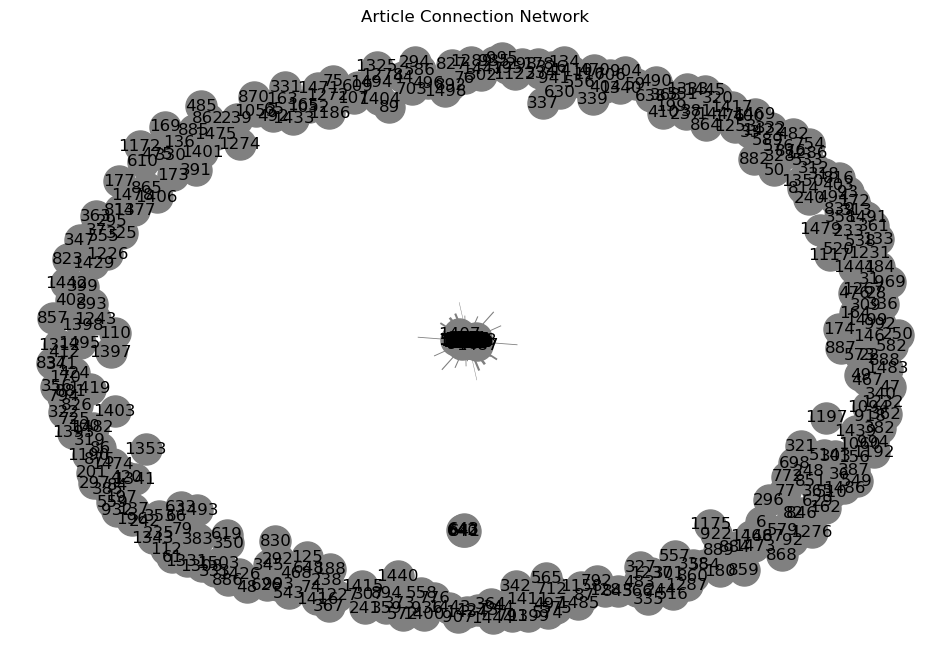

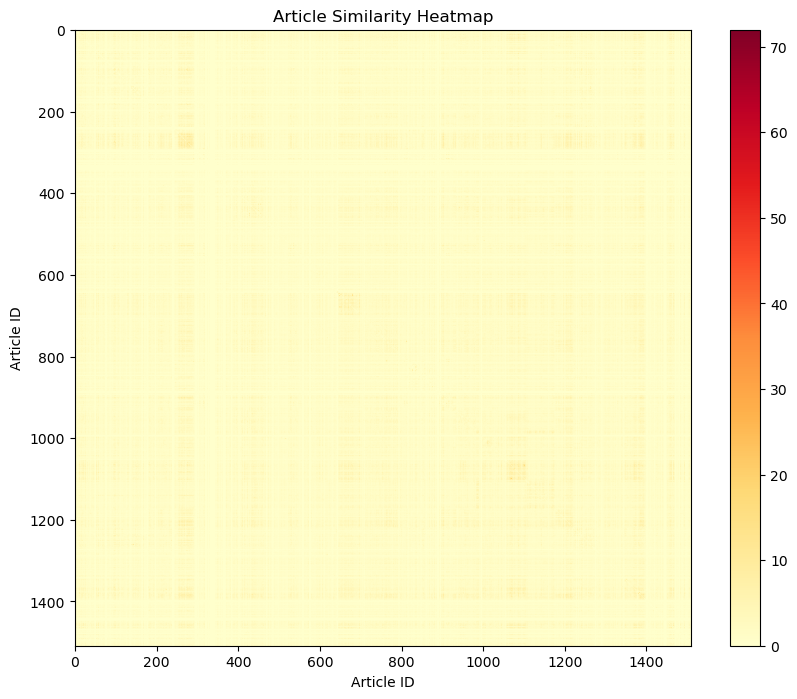

(array([-1, -1, -1, ..., -1, -1, -1], dtype=int64),
 {'shared_entities': {'0-3': 1,
   '0-5': 3,
   '0-8': 2,
   '0-9': 1,
   '0-10': 2,
   '0-11': 1,
   '0-13': 2,
   '0-14': 1,
   '0-15': 1,
   '0-16': 2,
   '0-17': 2,
   '0-19': 2,
   '0-21': 2,
   '0-24': 2,
   '0-25': 1,
   '0-26': 1,
   '0-27': 3,
   '0-30': 1,
   '0-32': 2,
   '0-34': 1,
   '0-39': 2,
   '0-42': 2,
   '0-43': 1,
   '0-45': 2,
   '0-46': 2,
   '0-51': 1,
   '0-52': 3,
   '0-53': 1,
   '0-55': 1,
   '0-56': 2,
   '0-60': 1,
   '0-63': 1,
   '0-68': 2,
   '0-70': 1,
   '0-71': 1,
   '0-73': 1,
   '0-80': 2,
   '0-81': 1,
   '0-85': 2,
   '0-88': 3,
   '0-91': 1,
   '0-94': 2,
   '0-95': 1,
   '0-97': 1,
   '0-98': 1,
   '0-99': 2,
   '0-101': 1,
   '0-102': 1,
   '0-104': 1,
   '0-105': 2,
   '0-106': 2,
   '0-113': 1,
   '0-114': 1,
   '0-115': 1,
   '0-118': 1,
   '0-119': 1,
   '0-120': 1,
   '0-122': 1,
   '0-127': 3,
   '0-129': 3,
   '0-130': 2,
   '0-138': 1,
   '0-140': 1,
   '0-148': 3,
   '0-149': 2,
   '

In [51]:
analyze_and_visualize(df)

In [74]:
def analyze_network_metrics(G):
    metrics = {
        'key_articles': [],
        'clusters': [],
        'connection_strength': {}
    }
    
    # Find most central articles
    centrality = nx.degree_centrality(G)
    metrics['key_articles'] = sorted(centrality.items(), 
                                   key=lambda x: x[1], 
                                   reverse=True)[:5]
    
    # Find strongest connections
    for (u, v, d) in G.edges(data=True):
        metrics['connection_strength'][(u,v)] = d['weight']
    
    return metrics

In [75]:
def generate_network_summary(G, metrics):
    summary = {
        'total_articles': len(G.nodes()),
        'total_connections': len(G.edges()),
        'key_findings': {
            'central_articles': [f"Article {art[0]} (centrality: {art[1]:.3f})" 
                               for art in metrics['key_articles']],
            'strongest_connections': sorted(metrics['connection_strength'].items(), 
                                         key=lambda x: x[1], 
                                         reverse=True)[:5]
        }
    }
    return summary

In [76]:
def enhanced_visualization(G, df):
    # Assuming df has columns like 'title', 'date', etc.
    node_info = {}
    for node in G.nodes():
        article_data = df.iloc[node]  # Get article data using ID
        node_info[node] = {
            'article_id': node,
            # 'title': article_data.get('title', f'Article {node}'),
            # 'date': article_data.get('date', 'Unknown'),
            'num_connections': len(list(G.neighbors(node))),
            'entities': [rel.get('entity1') for rel in article_data['entities']][:5]  # Show first 5 entities
        }

In [77]:
def get_article_connections(article_id, G, df):
    """Get detailed information about an article's connections"""
    neighbors = G.neighbors(article_id)
    connections = []
    
    for neighbor in neighbors:
        shared_entities = []
        for relation in df.iloc[article_id]['entities']:
            if relation.get('entity1') in [r.get('entity1') for r in df.iloc[neighbor]['entities']]:
                shared_entities.append(relation.get('entity1'))
                
        connections.append({
            'connected_to': neighbor,
            'shared_entities': shared_entities,
            'connection_strength': G[article_id][neighbor]['weight']
        })
    
    return connections

In [83]:
import networkx as nx
import plotly.graph_objects as go

# Your existing code for creating the graph remains the same
G = nx.Graph()
for i in range(len(df)):
    G.add_node(i)

for i in range(len(df)):
    for j in range(i + 1, len(df)):
        entities1 = set(rel['entity1'] for rel in df.iloc[i]['entities'] if 'entity1' in rel)
        entities2 = set(rel['entity1'] for rel in df.iloc[j]['entities'] if 'entity1' in rel)
        shared = len(entities1.intersection(entities2))
        if shared > 0:
            G.add_edge(i, j, weight=shared)

def create_enhanced_visualization(G, connections):
    # Calculate node properties
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    
    # Create a circular layout
    pos = nx.circular_layout(G)
    
    # Create node traces
    node_trace = go.Scatter(
        x=[pos[node][0] for node in G.nodes()],
        y=[pos[node][1] for node in G.nodes()],
        mode='markers+text',
        marker=dict(
            size=[degree_centrality[node] * 1000 for node in G.nodes()],
            color=list(betweenness_centrality.values()),
            colorscale='Viridis',
            showscale=True
        ),
        text=[f"Article {node}" for node in G.nodes()],
        hovertext=[f"Article {node}<br>"
                   f"Connections: {len(list(G.neighbors(node)))}<br>"
                   f"Centrality: {degree_centrality[node]:.3f}" 
                   for node in G.nodes()],
        hoverinfo='text'
    )
    
    # Create edge traces
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )
    
    # Create the figure
    fig = go.Figure(data=[edge_trace, node_trace],
                   layout=go.Layout(
                       showlegend=False,
                       hovermode='closest',
                       margin=dict(b=20,l=5,r=5,t=40),
                       title="Article Network Visualization"
                   ))
    
    return fig

# Create the visualization and save to HTML file
fig = create_enhanced_visualization(G, connections)
fig.write_html("article_network.html")

# Print network summary
print("\nNetwork Summary:")
print(f"Total Articles: {len(G.nodes())}")
print(f"Total Connections: {len(G.edges())}")

# Get and print metrics
metrics = analyze_network_metrics(G)
summary = generate_network_summary(G, metrics)
print("\nMost Central Articles:")
for article in summary['key_findings']['central_articles']:
    article_id = int(article.split()[1])
    print(f"{article}")


Network Summary:
Total Articles: 1509
Total Connections: 338874

Most Central Articles:
Article 1202 (centrality: 0.716)
Article 409 (centrality: 0.681)
Article 1054 (centrality: 0.671)
Article 1383 (centrality: 0.668)
Article 1386 (centrality: 0.659)


In [87]:
def analyze_central_article(article_id, df, G):
    # Get article info
    article = df.iloc[article_id]
    
    # Get all entities in the article
    entities = [rel['entity1'] for rel in article['entities'] if 'entity1' in rel and rel['entity1'] is not None]
    
    # Get all connections
    connections = get_article_connections(article_id, G, df)
    
    print(f"\nAnalysis of Article {article_id}:")
    print(f"Article Link: {article['Link']}")
    print(f"Number of connections: {len(connections)}")
    print(f"\nKey entities in this article:")
    print(set(entities))  # Using set to show unique entities
    
    # Show connection strengths
    print(f"\nStrongest connections:")
    sorted_connections = sorted(connections, key=lambda x: x['connection_strength'], reverse=True)
    for conn in sorted_connections[:5]:  # Show top 5 strongest connections
        connected_article = df.iloc[conn['connected_to']]
        
        # Filter out None values from shared entities
        shared_entities = [entity for entity in conn['shared_entities'] if entity is not None]
        
        print(f"\nConnected to Article {conn['connected_to']}")
        print(f"Connected article link: {connected_article['Link']}")
        print(f"Shared entities: {shared_entities}")
        print(f"Connection strength: {conn['connection_strength']}")

# Get the most central articles
central_articles = [
    (1202, 0.716),
    (409, 0.681),
    (1054, 0.671),
    (1383, 0.668),
    (1386, 0.659)
]

# Analyze each central article
print("=== ANALYSIS OF MOST CENTRAL ARTICLES ===")
for article_id, centrality in central_articles:
    print("\n" + "="*50)
    print(f"Analyzing article {article_id} (centrality: {centrality:.3f})")
    print("="*50)
    analyze_central_article(article_id, df, G)


=== ANALYSIS OF MOST CENTRAL ARTICLES ===

Analyzing article 1202 (centrality: 0.716)

Analysis of Article 1202:
Article Link: https://www.straitstimes.com/life/style/tired-of-the-usual-beauty-products-meet-3-new-to-s-pore-brands-disrupting-the-industry
Number of connections: 1079

Key entities in this article:
{'six', '299', 'Seven years ago', 'Jubilee Skincare', 'Singapore', 'the United States', '2000', 'monthly', '23', 'April', 'photo gin tay', '25', 'Ms Lee', 'Jubilee Skincare Inc', 'Naiian Eye Face', 'MODULES Modules', '28', '20', 'The Straits Times', 'B Corp', 'Olive Young', '25 to 35', 'Cheung', 'Hong Kongborn Canadian', '2018', 'Melixirs', 'Canadian', 'Seouls Hannamdong', 'Airbnb', 'First', 'Chinese', '54yearold', '209', 'MODULES Prescription', '2017', '49', 'Acid Moisturiser', 'Thailand', '$10M', 'New Zealand', 'Shanghai', 'one', 'Naiians', 'Orchard Road', 'Jewel In The Palace', '44', 'Ora Group', 'the Harvard Business School', 'Apex Medical Center', 'French', '2003 to 2004', 

In [88]:
analyze_central_article(409, df, G)



Analysis of Article 409:
Article Link: https://www.straitstimes.com/life/home-design/medtech-marvels-usher-in-a-new-era-of-healthcare
Number of connections: 1027

Key entities in this article:
{'over $1 billion', 'six', '42', 'AsiaPacific', 'the European Union', 'the Alexandra Virtual Hospital', 'Singapore Management University', 'Jamille Closa', 'Singapore', 'the United States', '800kg', '2000', '2.0', 'Centre', 'dr Edison', 'daily', 'The 3D Printing Centre', 'Spectra', 'Meracle', 'more than a hundred', 'the same year', 'SGH Singapores', 'Dr Koh Tsingyi', 'Chee Shu Ping', 'less than three hours', 'Mount Elizabeth Hospital', '2018', 'Dacy', '3cm', '3dprinted', 'the National University Hospital and', 'NUH', 'Dr Yip', 'the Smart Ward', 'almost $213 billion', 'the Anto Smart Cushion', 'clinicians', 'Healthcare CIH', 'Yip', 'Alexandra Hospital', 'Chins', 'IoMT', 'more than 15 years', '3d', 'Rebee Health', '39yearold', 'Jada Seet', 'CT', 'the SGH Department of Diagnostic Radiology', 'built

In [ ]:
import itertools
from collections import defaultdict

def process_entity(entity_text):
    """
    Process a given entity string by lowercasing, removing stopwords,
    and lemmatizing the tokens. Only alphabetic tokens are retained.
    """
    # Process the entity text using spaCy
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(entity_text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    # Join the tokens back together
    processed = " ".join(tokens)
    return processed

def aggregate_entity_cooccurrence(df, entity_column='entities'):
    """
    Aggregates the co-occurrence counts of specific entities (after processing)
    across the entire dataframe.

    Parameters:
    - df: pandas DataFrame that includes an `entity_column`
    - entity_column: name of the column containing entity extraction results,
      which is expected to be a list of dictionaries with at least the key 'entity1'

    Returns:
    - A dictionary with keys as tuples of (entity1, entity2) and values as the co-occurrence counts.
    """
    cooccurrence_counts = defaultdict(int)
    
    # Iterate over each row in the dataframe
    for idx, row in df.iterrows():
        # Extract the list of entities from the specified column
        entities_list = row.get(entity_column, [])
        entity_names = []
        
        for entity in entities_list:
            if isinstance(entity, dict) and 'entity1' in entity:
                raw_entity = entity['entity1']
                processed_entity = process_entity(raw_entity)
                if processed_entity:  # Only add if non-empty after processing
                    entity_names.append(processed_entity)
            elif isinstance(entity, str):
                processed_entity = process_entity(entity)
                if processed_entity:
                    entity_names.append(processed_entity)
        
        # Remove duplicates within the same article
        unique_entities = list(set(entity_names))
        
        # Continue only if there are at least two unique entities
        if len(unique_entities) < 2:
            continue
        
        # Generate all unique pairs (order-insensitive)
        for pair in itertools.combinations(sorted(unique_entities), 2):
            cooccurrence_counts[pair] += 1
            
    return cooccurrence_counts

# Example usage:
# Assuming you have your dataframe `df` already loaded with an 'entities' column
co_occurrence = aggregate_entity_cooccurrence(df, entity_column='entities')

# To view the top co-occurring entity pairs:
sorted_co_occurrence = sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True)

print("Top 10 specific entity co-occurrence pairs (Entity Pair, Count):")
for pair, count in sorted_co_occurrence[:10]:
    print(f"{pair}: {count}")

# Optionally, convert the dictionary into a DataFrame for easier analysis or visualization
cooccurrence_df = pd.DataFrame([
    {'Entity 1': pair[0], 'Entity 2': pair[1], 'Count': count}
    for pair, count in co_occurrence.items()
])
print("\nAggregate Specific Entity Co-occurrence DataFrame:")
print(cooccurrence_df.sort_values(by='Count', ascending=False).head(10))
